Random forests grow a number of decision trees and, for each tree, train it on a training set by choosing n training examples from the training set, smapling with replacement. For each node of the tree, m features are randomly selected and the best split is calculated. Each tree is usually fully grown and not pruned, unlike decision trees, and majority voting is used to determine the final predictions.

In [1]:
# import libraries
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

In [2]:
# import datasets
X_train = pd.read_csv('/Users/alessia/Desktop/churn/X_train.csv')
y_train = pd.read_csv('/Users/alessia/Desktop/churn/y_train.csv')
X_test = pd.read_csv('/Users/alessia/Desktop/churn/X_test.csv')
y_test = pd.read_csv('/Users/alessia/Desktop/churn/y_test.csv')

In [3]:
# parameter grid
param_grid = { 'criterion' : ['gini', 'entropy'],
    'max_depth': [None, 5],
    'n_estimators' : [400]
}

# bootstrap is True by default: at every iteration, a tree is trained on 2/3 of the dataset

# Random Forest
rf_classifier = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid,
                           scoring='roc_auc', cv=5)
grid_search.fit(X_train, y_train.values.ravel()) 

print("Best Parameters: ", grid_search.best_params_)
print("Best AUC: {:.4f}".format(grid_search.best_score_))

Best Parameters:  {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 400}
Best AUC: 0.8784


In [4]:
random_forest = grid_search.best_estimator_ # select best estimator based on best parameters

# refit model on training set
random_forest.fit(X = X_train, y = y_train.values.ravel())

# predict on the training set
y_pred_train = random_forest.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
print(f"Accuracy on training set: {accuracy_train:.4f}")

# AUC on training set
y_probs_train = random_forest.predict_proba(X_train)[:, 1] # compute probabilities

# ROC curve
fpr_train, tpr_train, thresholds = roc_curve(y_train, y_probs_train)

# AUC
roc_auc_train = auc(fpr_train, tpr_train)
print('AUC on training set is {}'.format(roc_auc_train))


# predict on the test set
y_pred_test = random_forest.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Accuracy on test set: {accuracy_test:.4f}")

# AUC on test set
y_probs_test = random_forest.predict_proba(X_test)[:, 1] # compute probabilities

# ROC curve
fpr_test, tpr_test, thresholds = roc_curve(y_test, y_probs_test)

# AUC
roc_auc_test = auc(fpr_test, tpr_test)
print('AUC on test set is {}'.format(roc_auc_test))

Accuracy on training set: 0.8504
AUC on training set is 0.8791927626884862
Accuracy on test set: 0.8510
AUC on test set is 0.8789118643162394


In [5]:
# define confusion matrix
import seaborn as sns

classes = ['Non churner', 'Churner']

def plot_confusionmatrix(y_train_pred,y_train):
    cf = confusion_matrix(y_train_pred,y_train)
    sns.heatmap(cf,annot=True,yticklabels=classes
               ,xticklabels=classes,cmap='YlGn', fmt='g')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

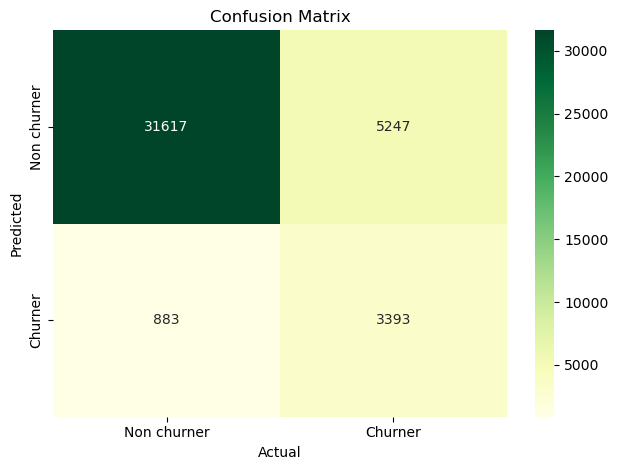

In [6]:
# confusion matrix
plt.title('Confusion matrix')
plot_confusionmatrix(y_pred_test,y_test)

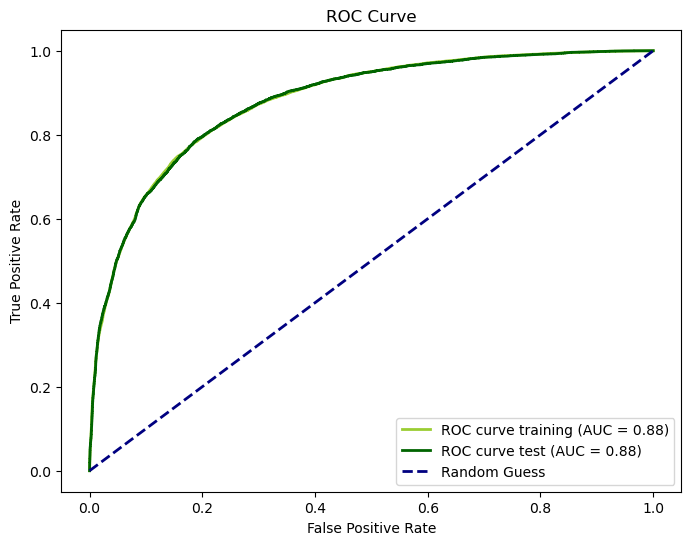

In [7]:
# ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='yellowgreen', lw=2, label=f'ROC curve training (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color = 'darkgreen', lw= 2, label=f'ROC curve test (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.plot([])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [8]:
# compute other evaluation measures
from sklearn.metrics import precision_score, recall_score, f1_score
# precision (recall)
precision_test = precision_score(y_test, y_pred_test)
# recall
recall_test = recall_score(y_test, y_pred_test)
# f1-measure
f1_test = f1_score(y_test, y_pred_test)

print('Precision on the test set is {}'.format(precision_test))
print('Recall on the test set is {}'.format(recall_test))
print('f1-measure on the test set is {}'.format(f1_test))

Precision on the test set is 0.7934985968194574
Recall on the test set is 0.3927083333333333
f1-measure on the test set is 0.5253948590895015


In [9]:
# Save model
model_name='random_forest.pkl'
model_file=open(model_name,'wb')
pickle.dump(random_forest, model_file)
model_file.close()
# Open model
model_file=open(model_name, 'rb')
Model=pickle.load(model_file)